In [125]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

import xgboost as xgb

from sktime.performance_metrics.forecasting import mean_absolute_error
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.base import ForecastingHorizon

from tabulate import tabulate

# **Wind Farm #1**

In [85]:
DATA_PATH = 'Datasets'

df_wf1 = pd.read_excel(
    os.path.join(DATA_PATH,'Wind farm site 1 (Nominal capacity-99MW).xlsx'), 
)

pd.set_option('display.max_columns', None)
df_wf1

,Time(year-month-day h:m:s),Wind speed at height of 10 meters (m/s),Wind direction at height of 10 meters (˚),Wind speed at height of 30 meters (m/s),Wind direction at height of 30 meters (˚),Wind speed at height of 50 meters (m/s),Wind direction at height of 50 meters (˚),Wind speed - at the height of wheel hub (m/s),Wind speed - at the height of wheel hub (˚),Air temperature (°C),Atmosphere (hpa),Relative humidity (%),Power (MW)
0,2019-01-01 00:00:00,2.209,81.317,1.991,74.814,2.094,77.667,2.494,74.500,-13.484,889.867,76.320,0.254383
1,2019-01-01 00:15:00,1.828,77.460,1.698,75.048,1.757,88.733,1.882,74.367,-13.691,889.575,76.757,0.329703
2,2019-01-01 00:30:00,2.193,86.700,2.313,84.688,2.344,89.100,2.350,89.000,-13.766,889.942,76.981,0.296306
3,2019-01-01 00:45:00,2.654,78.160,2.494,74.939,2.574,87.267,2.808,82.733,-13.691,889.675,76.821,0.187590
4,2019-01-01 01:00:00,2.249,94.297,2.192,91.140,2.558,96.900,2.924,92.967,-13.447,890.025,74.571,0.081005
...,...,...,...,...,...,...,...,...,...,...,...,...,...
70171,2020-12-31 22:45:00,5.738,234.600,6.408,235.454,6.575,242.033,6.680,238.433,-9.108,890.008,53.312,13.633642
70172,2020-12-31 23:00:00,5.748,229.333,6.231,233.423,6.372,239.800,6.448,236.833,-9.978,889.817,53.877,6.869759
70173,2020-12-31 23:15:00,4.468,235.133,4.406,253.261,4.381,263.400,4.399,261.733,-9.808,889.825,54.437,4.352931
70174,2020-12-31 23:30:00,3.730,242.580,3.280,252.492,3.204,268.600,3.446,266.733,-9.633,889.492,54.677,7.185250


In [86]:
df_wf1.columns=['time','WS_10','WD_10','WS_30','WD_30','WS_50','WD_50','WS_cen','WD_cen','Air_T','Air_P','Air_H','Power(MW)']

In [87]:
df_wf1.columns = [col.strip() for col in df_wf1.columns]

In [88]:
df_wf1.describe()

,WS_10,WD_10,WS_30,WD_30,WS_50,WD_50,WS_cen,WD_cen,Air_T,Air_P,Air_H,Power(MW)
count,70176.000000,70176.000000,70176.000000,70176.000000,70176.000000,70176.000000,70176.000000,70176.000000,70176.000000,70176.000000,70176.000000,70176.000000
mean,5.711011,222.829748,6.039255,220.633957,6.168763,221.868203,6.375876,216.986224,8.543324,889.527469,37.581143,23.426896
std,3.119512,73.705902,3.700131,79.846922,3.874708,83.092270,3.907965,85.404564,13.368410,2.439019,18.896256,24.130181
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-24.131000,858.400000,1.502000,0.000000
25%,3.538000,209.431500,3.302000,192.871000,3.194000,169.800000,3.300000,144.067000,-3.271000,889.550000,22.355000,1.572839
50%,5.389000,235.987000,5.783000,245.442000,5.811000,251.833000,5.879500,248.825000,9.823000,889.742000,34.401500,14.957783
75%,7.217250,275.287000,8.091000,277.580250,8.384000,281.433000,8.604000,279.304250,19.756000,889.925000,51.584000,40.215230
max,25.465000,358.987000,29.187000,359.087000,29.678000,358.933000,30.247000,358.500000,36.130000,918.192000,93.120000,98.094440


In [89]:
df_wf1[df_wf1['Power(MW)'] == 0.0]

,time,WS_10,WD_10,WS_30,WD_30,WS_50,WD_50,WS_cen,WD_cen,Air_T,Air_P,Air_H,Power(MW)
39247,2020-02-13 19:45:00,3.378,125.700,4.118,111.548,4.456,114.367,4.631,110.267,-1.859,889.567,24.475,0.0
39248,2020-02-13 20:00:00,3.343,128.193,4.602,109.619,4.861,111.433,5.040,105.733,-2.201,890.200,25.381,0.0
39249,2020-02-13 20:15:00,3.448,142.987,4.513,115.724,4.681,116.833,4.736,110.300,-2.814,890.283,25.963,0.0
39250,2020-02-13 20:30:00,3.503,147.780,4.755,117.541,4.727,119.900,4.728,114.000,-2.753,889.583,25.968,0.0
39251,2020-02-13 20:45:00,3.656,139.320,4.862,111.267,5.121,112.900,5.258,108.533,-3.267,890.100,26.437,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
57589,2020-08-22 21:15:00,6.288,266.327,7.827,264.050,8.048,268.900,8.369,266.983,22.202,889.400,23.480,0.0
57590,2020-08-22 21:30:00,6.451,260.760,7.705,262.396,8.150,267.700,8.494,264.900,21.460,889.717,24.067,0.0
57591,2020-08-22 21:45:00,5.180,258.653,6.334,259.231,6.924,265.633,7.119,260.400,21.502,889.567,24.744,0.0
57592,2020-08-22 22:00:00,5.211,241.840,6.157,245.209,6.550,253.367,6.766,248.783,21.014,889.550,25.536,0.0


In [90]:
df_wf1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70176 entries, 0 to 70175
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   time       70176 non-null  object 
 1   WS_10      70176 non-null  float64
 2   WD_10      70176 non-null  float64
 3   WS_30      70176 non-null  float64
 4   WD_30      70176 non-null  float64
 5   WS_50      70176 non-null  float64
 6   WD_50      70176 non-null  float64
 7   WS_cen     70176 non-null  float64
 8   WD_cen     70176 non-null  float64
 9   Air_T      70176 non-null  float64
 10  Air_P      70176 non-null  float64
 11  Air_H      70176 non-null  float64
 12  Power(MW)  70176 non-null  float64
dtypes: float64(12), object(1)
memory usage: 7.0+ MB


In [91]:
df_wf1['time'] = pd.to_datetime(df_wf1['time'], format='%Y-%m-%d %H:%M:%S')

In [92]:
df_wf1.isnull().mean()

time         0.0
WS_10        0.0
WD_10        0.0
WS_30        0.0
WD_30        0.0
WS_50        0.0
WD_50        0.0
WS_cen       0.0
WD_cen       0.0
Air_T        0.0
Air_P        0.0
Air_H        0.0
Power(MW)    0.0
dtype: float64

In [93]:
df_wf1

,time,WS_10,WD_10,WS_30,WD_30,WS_50,WD_50,WS_cen,WD_cen,Air_T,Air_P,Air_H,Power(MW)
0,2019-01-01 00:00:00,2.209,81.317,1.991,74.814,2.094,77.667,2.494,74.500,-13.484,889.867,76.320,0.254383
1,2019-01-01 00:15:00,1.828,77.460,1.698,75.048,1.757,88.733,1.882,74.367,-13.691,889.575,76.757,0.329703
2,2019-01-01 00:30:00,2.193,86.700,2.313,84.688,2.344,89.100,2.350,89.000,-13.766,889.942,76.981,0.296306
3,2019-01-01 00:45:00,2.654,78.160,2.494,74.939,2.574,87.267,2.808,82.733,-13.691,889.675,76.821,0.187590
4,2019-01-01 01:00:00,2.249,94.297,2.192,91.140,2.558,96.900,2.924,92.967,-13.447,890.025,74.571,0.081005
...,...,...,...,...,...,...,...,...,...,...,...,...,...
70171,2020-12-31 22:45:00,5.738,234.600,6.408,235.454,6.575,242.033,6.680,238.433,-9.108,890.008,53.312,13.633642
70172,2020-12-31 23:00:00,5.748,229.333,6.231,233.423,6.372,239.800,6.448,236.833,-9.978,889.817,53.877,6.869759
70173,2020-12-31 23:15:00,4.468,235.133,4.406,253.261,4.381,263.400,4.399,261.733,-9.808,889.825,54.437,4.352931
70174,2020-12-31 23:30:00,3.730,242.580,3.280,252.492,3.204,268.600,3.446,266.733,-9.633,889.492,54.677,7.185250


Power(MW) column deals with 0.0 values, hence we will remove these rows to have realistic MAPE calculations.

## **Pairplots**

In [94]:
#sns.pairplot(df_wf1, hue=None, size=2.5)

## **Correlation matrix**

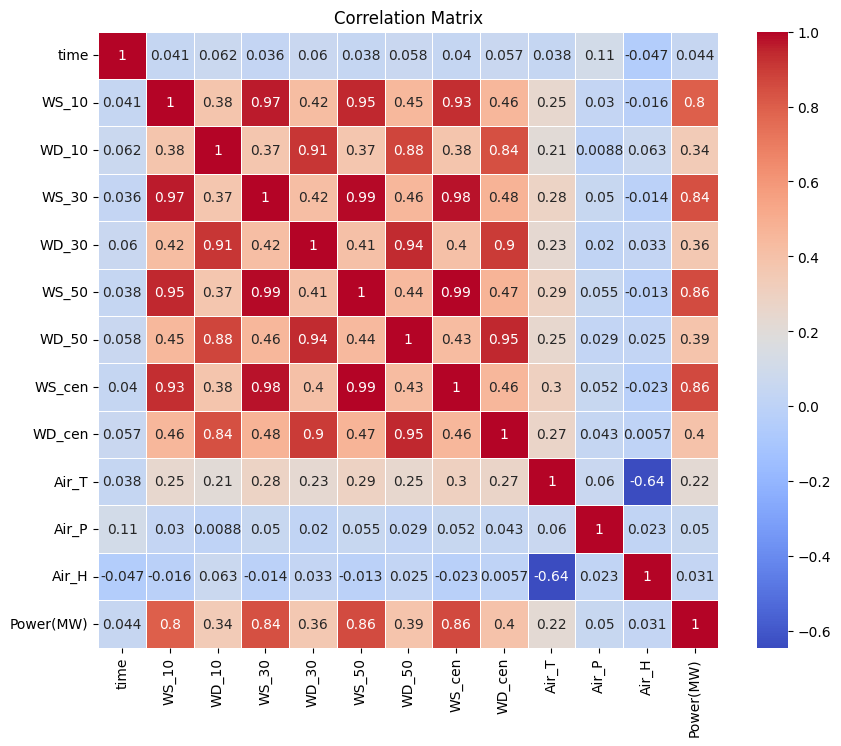

In [95]:
correlation_matrix = df_wf1.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

In [96]:
pearsonr(df_wf1['WS_10'], df_wf1['Power(MW)'])

PearsonRResult(statistic=0.7998595044473422, pvalue=0.0)

In [97]:
pearsonr(df_wf1['WS_30'], df_wf1['Power(MW)'])

PearsonRResult(statistic=0.8399594587604483, pvalue=0.0)

In [98]:
pearsonr(df_wf1['WS_50'], df_wf1['Power(MW)'])

PearsonRResult(statistic=0.8563136119964403, pvalue=0.0)

In [99]:
pearsonr(df_wf1['WS_cen'], df_wf1['Power(MW)'])

PearsonRResult(statistic=0.8617302465680093, pvalue=0.0)

With respect to the target variable [Power (MW)], the 4 below features have high correlations on top of very significant pvalues:
- 0.8 with Wind speed at height of 10 meters (m/s)
- 0.84 with Wind speed at height of 30 meters (m/s)
- 0.86 with Wind speed at height of 50 meters (m/s)
- 0.86 with Wind speed - at the height of wheel hub (m/s)

In [100]:
df_wf1.set_index('time', inplace=True)

In [101]:
df_wf1

,WS_10,WD_10,WS_30,WD_30,WS_50,WD_50,WS_cen,WD_cen,Air_T,Air_P,Air_H,Power(MW)
time,,,,,,,,,,,,
2019-01-01 00:00:00,2.209,81.317,1.991,74.814,2.094,77.667,2.494,74.500,-13.484,889.867,76.320,0.254383
2019-01-01 00:15:00,1.828,77.460,1.698,75.048,1.757,88.733,1.882,74.367,-13.691,889.575,76.757,0.329703
2019-01-01 00:30:00,2.193,86.700,2.313,84.688,2.344,89.100,2.350,89.000,-13.766,889.942,76.981,0.296306
2019-01-01 00:45:00,2.654,78.160,2.494,74.939,2.574,87.267,2.808,82.733,-13.691,889.675,76.821,0.187590
2019-01-01 01:00:00,2.249,94.297,2.192,91.140,2.558,96.900,2.924,92.967,-13.447,890.025,74.571,0.081005
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 22:45:00,5.738,234.600,6.408,235.454,6.575,242.033,6.680,238.433,-9.108,890.008,53.312,13.633642
2020-12-31 23:00:00,5.748,229.333,6.231,233.423,6.372,239.800,6.448,236.833,-9.978,889.817,53.877,6.869759
2020-12-31 23:15:00,4.468,235.133,4.406,253.261,4.381,263.400,4.399,261.733,-9.808,889.825,54.437,4.352931


In [102]:
df_wf1 = df_wf1.asfreq('15T')
print(df_wf1.index.freq)

<15 * Minutes>


## **Preparing training, testing and demo datasets**

We will slip the entire .csv file into three subdatasets:

- **Modeling**
1. Training (to input training data into forecasting models)
2. Testing (to test forecasting models comparing forcasting with testing data)

- **Demo**
3. Historical (to refit the training+testing with real data after each user forecast request; 1 month of data)

In [130]:
one_month_range = df_wf1.index.max() - pd.DateOffset(months=1)
df_demo = df_wf1[df_wf1.index >= one_month_range]

df_wf1_model = df_wf1[df_wf1.index < one_month_range]

df_wf1_first_50, df_wf1_last_50 = train_test_split(df_wf1_model, train_size = 0.5, test_size = 0.5, shuffle=False)

df_wf1_first_25, df_wf1_second_25 = train_test_split(df_wf1_first_50, train_size = 0.5, test_size = 0.5, shuffle=False)
df_wf1_third_25, df_wf1_fourth_25 = train_test_split(df_wf1_last_50, train_size = 0.5, test_size = 0.5, shuffle=False)

df_wf1_1_train, df_wf1_1_test = train_test_split(df_wf1_first_25, train_size = 0.96, test_size = 0.04, shuffle=False)
df_wf1_2_train, df_wf1_2_test = train_test_split(df_wf1_second_25, train_size = 0.96, test_size = 0.04, shuffle=False)
df_wf1_3_train, df_wf1_3_test = train_test_split(df_wf1_third_25, train_size = 0.96, test_size = 0.04, shuffle=False)
df_wf1_4_train, df_wf1_4_test = train_test_split(df_wf1_fourth_25, train_size = 0.96, test_size = 0.04, shuffle=False)

In [131]:
y_train_1 = df_wf1_1_train[['Power(MW)']]
X_train_1 = df_wf1_1_train[['WD_cen', 'WS_cen']]

y_train_2 = df_wf1_2_train[['Power(MW)']]
X_train_2 = df_wf1_2_train[['WD_cen', 'WS_cen']]

y_train_3 = df_wf1_3_train[['Power(MW)']]
X_train_3 = df_wf1_3_train[['WD_cen', 'WS_cen']]

y_train_4 = df_wf1_4_train[['Power(MW)']]
X_train_4 = df_wf1_4_train[['WD_cen', 'WS_cen']]

train_datasets = [(y_train_1, X_train_1), (y_train_2, X_train_2), (y_train_3, X_train_3), (y_train_4, X_train_4)]

In [132]:
y_test_1 = df_wf1_1_test[['Power(MW)']]
X_test_1 = df_wf1_1_test[['WD_cen', 'WS_cen']]

y_test_2 = df_wf1_2_test[['Power(MW)']]
X_test_2 = df_wf1_2_test[['WD_cen', 'WS_cen']]

y_test_3 = df_wf1_3_test[['Power(MW)']]
X_test_3 = df_wf1_3_test[['WD_cen', 'WS_cen']]

y_test_4 = df_wf1_4_test[['Power(MW)']]
X_test_4 = df_wf1_4_test[['WD_cen', 'WS_cen']]

test_datasets = [(y_test_1, X_test_1), (y_test_2, X_test_2), (y_test_3, X_test_3), (y_test_4, X_test_4)]

In [106]:
print(df_wf1.index.freq)

<15 * Minutes>


## **Naïve forecaster model**

In [151]:
naive_predictions_dict = {}

for i, (y_train, _) in enumerate(train_datasets, 1):
    y_test, _ = test_datasets[i - 1]

    forecast_naive = NaiveForecaster(strategy="last")
    forecasted_naive = forecast_naive.fit(y_train)

    forecast_horizon = ForecastingHorizon([i for i in range(1, len(y_test) + 1)])

    predictions_naive = forecasted_naive.predict(fh=forecast_horizon)

    naive_predictions_dict[f'predictions_{i}'] = predictions_naive

y_pred_naive_1 = naive_predictions_dict['predictions_1']
y_pred_naive_2 = naive_predictions_dict['predictions_2']
y_pred_naive_3 = naive_predictions_dict['predictions_3']
y_pred_naive_4 = naive_predictions_dict['predictions_4']

## **Linear regression model**

In [156]:
linear_predictions_dict = {}

for i, (y_train, X_train) in enumerate(train_datasets, 1):
    _, X_test = test_datasets[i - 1]

    linear_model = LinearRegression()
    linear_model.fit(X_train, y_train)
    
    predictions_linear = linear_model.predict(X_test)
    predictions_linear_df = pd.DataFrame(predictions_linear, index=X_test.index, columns=['Predicted Power(MW)'])

    linear_predictions_dict[f'predictions_{i}'] = predictions_linear_df

y_pred_linear_1 = linear_predictions_dict['predictions_1']
y_pred_linear_2 = linear_predictions_dict['predictions_2']
y_pred_linear_3 = linear_predictions_dict['predictions_3']
y_pred_linear_4 = linear_predictions_dict['predictions_4']

## **LSTM - Long short-term memory model**

In [107]:
def train_and_forecast_lstm(X_train, y_train, X_test):
    X_train_lstm = X_train.values.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test_lstm = X_test.values.reshape(X_test.shape[0], 1, X_test.shape[1])

    model_lstm = Sequential()
    model_lstm.add(LSTM(units=85, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
    model_lstm.add(Dense(units=1))
    model_lstm.compile(optimizer='adam', loss='mean_squared_error')

    model_lstm.fit(X_train_lstm, y_train, epochs=80, batch_size=50, verbose=0)

    predictions = model_lstm.predict(X_test_lstm)
    predictions_lstm = pd.DataFrame(predictions, index=X_test.index, columns=['Predicted Power(MW)'])

    return predictions_lstm

train_datasets = [(y_train_1, X_train_1), (y_train_2, X_train_2), (y_train_3, X_train_3), (y_train_4, X_train_4)]
test_datasets = [(y_test_1, X_test_1), (y_test_2, X_test_2), (y_test_3, X_test_3), (y_test_4, X_test_4)]

predictions_lstm_dict = {}

for i, (y_train, X_train) in enumerate(train_datasets, 1):
    y_test, X_test = test_datasets[i - 1]
    
    predictions_lstm = train_and_forecast_lstm(X_train, y_train, X_test)
    
    predictions_lstm_dict[f'predictions_{i}'] = predictions_lstm

y_pred_lstm_1 = predictions_lstm_dict['predictions_1']
y_pred_lstm_2 = predictions_lstm_dict['predictions_2']
y_pred_lstm_3 = predictions_lstm_dict['predictions_3']
y_pred_lstm_4 = predictions_lstm_dict['predictions_4']

C:\Users\mattd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


## **Random Forest model**

In [108]:
predictions_randomforest_dict = {}

for i, (y_train, X_train) in enumerate(train_datasets, 1):
    y_test, X_test = test_datasets[i - 1]
    
    randomforest_regressor = RandomForestRegressor(bootstrap=True, n_estimators=800, random_state=42)
    randomforest_regressor.fit(X_train, y_train)
    
    predictions = randomforest_regressor.predict(X_test)
    predictions_randomforest = pd.DataFrame(predictions, index=y_test.index, columns=['Predicted Power(MW)'])
    
    predictions_randomforest_dict[f'predictions_{i}'] = predictions_randomforest

y_pred_randomforest_1 = predictions_randomforest_dict['predictions_1']
y_pred_randomforest_2 = predictions_randomforest_dict['predictions_2']
y_pred_randomforest_3 = predictions_randomforest_dict['predictions_3']
y_pred_randomforest_4 = predictions_randomforest_dict['predictions_4']

C:\Users\mattd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mattd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\mattd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

## **XGBoost model**

In [109]:
predictions_xgboost_dict = {}

for i, (y_train, X_train) in enumerate(train_datasets, 1):
    y_test, X_test = test_datasets[i - 1]

    xgboost_model = xgb.XGBRegressor(max_depth=3, learning_rate=0.11, n_estimators=62)
    xgboost_model.fit(X_train, y_train)
    
    predictions = xgboost_model.predict(X_test)
    predictions_xgboost = pd.DataFrame(predictions, index=y_test.index, columns=['Predicted Power(MW)'])

    predictions_xgboost_dict[f'predictions_{i}'] = predictions_xgboost

y_pred_xgboost_1 = predictions_xgboost_dict['predictions_1']
y_pred_xgboost_2 = predictions_xgboost_dict['predictions_2']
y_pred_xgboost_3 = predictions_xgboost_dict['predictions_3']
y_pred_xgboost_4 = predictions_xgboost_dict['predictions_4']

## **Reduction Random Forest model**

In [111]:
predictions_reduction_randomforest_dict = {}

for i, (y_train, X_train) in enumerate(train_datasets, 1):
    y_test, X_test = test_datasets[i - 1]
    
    forecaster = make_reduction(randomforest_regressor, strategy='recursive', window_length=5)
    forecaster.fit(y_train)
    
    horizon = list(range(1, len(y_test) + 1))
    predictions_reductions_recursive = forecaster.predict(fh=horizon)
    
    predictions_reduction_randomforest_dict[f'predictions_{i}'] = predictions_reductions_recursive

y_pred_reduction_randomforest_1 = predictions_reduction_randomforest_dict['predictions_1']
y_pred_reduction_randomforest_2 = predictions_reduction_randomforest_dict['predictions_2']
y_pred_reduction_randomforest_3 = predictions_reduction_randomforest_dict['predictions_3']
y_pred_reduction_randomforest_4 = predictions_reduction_randomforest_dict['predictions_4']

In [112]:
predictions_reduction_xgboost_dict = {}

for i, (y_train, X_train) in enumerate(train_datasets, 1):
    y_test, X_test = test_datasets[i - 1]
    
    forecaster = make_reduction(xgboost_model, strategy='recursive', window_length=5)
    forecaster.fit(y_train)
    
    horizon = list(range(1, len(y_test) + 1))
    predictions_reductions_recursive = forecaster.predict(fh=horizon)
    
    predictions_reduction_xgboost_dict[f'predictions_{i}'] = predictions_reductions_recursive

y_pred_reduction_xgboost_1 = predictions_reduction_xgboost_dict['predictions_1']
y_pred_reduction_xgboost_2 = predictions_reduction_xgboost_dict['predictions_2']
y_pred_reduction_xgboost_3 = predictions_reduction_xgboost_dict['predictions_3']
y_pred_reduction_xgboost_4 = predictions_reduction_xgboost_dict['predictions_4']

## **Summary**

In [158]:
mae_naive_1 = mean_absolute_error(y_test_1, y_pred_naive_1)
mae_naive_2 = mean_absolute_error(y_test_2, y_pred_naive_2)
mae_naive_3 = mean_absolute_error(y_test_3, y_pred_naive_3)
mae_naive_4 = mean_absolute_error(y_test_4, y_pred_naive_4)
average_mae_naive = (mae_naive_1 + mae_naive_2 + mae_naive_3 + mae_naive_4) / 4

mae_linear_1 = mean_absolute_error(y_test_1, y_pred_linear_1)
mae_linear_2 = mean_absolute_error(y_test_2, y_pred_linear_2)
mae_linear_3 = mean_absolute_error(y_test_3, y_pred_linear_3)
mae_linear_4 = mean_absolute_error(y_test_4, y_pred_linear_4)
average_mae_linear = (mae_linear_1 + mae_linear_2 + mae_linear_3 + mae_linear_4) / 4

mae_lstm_1 = mean_absolute_error(y_test_1, y_pred_lstm_1)
mae_lstm_2 = mean_absolute_error(y_test_2, y_pred_lstm_2)
mae_lstm_3 = mean_absolute_error(y_test_3, y_pred_lstm_3)
mae_lstm_4 = mean_absolute_error(y_test_4, y_pred_lstm_4)
average_mae_lstm = (mae_lstm_1 + mae_lstm_2 + mae_lstm_3 + mae_lstm_4) / 4

mae_randomforest_1 = mean_absolute_error(y_test_1, y_pred_randomforest_1)
mae_randomforest_2 = mean_absolute_error(y_test_2, y_pred_randomforest_2)
mae_randomforest_3 = mean_absolute_error(y_test_3, y_pred_randomforest_3)
mae_randomforest_4 = mean_absolute_error(y_test_4, y_pred_randomforest_4)
average_mae_randomforest = (mae_randomforest_1 + mae_randomforest_2 + mae_randomforest_3 + mae_randomforest_4) / 4

mae_xgboost_1 = mean_absolute_error(y_test_1, y_pred_xgboost_1)
mae_xgboost_2 = mean_absolute_error(y_test_2, y_pred_xgboost_2)
mae_xgboost_3 = mean_absolute_error(y_test_3, y_pred_xgboost_3)
mae_xgboost_4 = mean_absolute_error(y_test_4, y_pred_xgboost_4)
average_mae_xgboost = (mae_xgboost_1 + mae_xgboost_2 + mae_xgboost_3 + mae_xgboost_4) / 4

mae_reduction_randomforest_1 = mean_absolute_error(y_test_1, y_pred_reduction_randomforest_1)
mae_reduction_randomforest_2 = mean_absolute_error(y_test_2, y_pred_reduction_randomforest_2)
mae_reduction_randomforest_3 = mean_absolute_error(y_test_3, y_pred_reduction_randomforest_3)
mae_reduction_randomforest_4 = mean_absolute_error(y_test_4, y_pred_reduction_randomforest_4)
average_mae_reduction_randomforest = (mae_reduction_randomforest_1 + mae_reduction_randomforest_2 + mae_reduction_randomforest_3 + mae_reduction_randomforest_4) / 4

mae_reduction_xgboost_1 = mean_absolute_error(y_test_1, y_pred_reduction_xgboost_1)
mae_reduction_xgboost_2 = mean_absolute_error(y_test_2, y_pred_reduction_xgboost_2)
mae_reduction_xgboost_3 = mean_absolute_error(y_test_3, y_pred_reduction_xgboost_3)
mae_reduction_xgboost_4 = mean_absolute_error(y_test_4, y_pred_reduction_xgboost_4)
average_mae_reduction_xgboost = (mae_reduction_xgboost_1 + mae_reduction_xgboost_2 + mae_reduction_xgboost_3 + mae_reduction_xgboost_4) / 4

In [160]:
models = [
    "Naive Forecaster",
    "Linear Regression",
    "LSTM (epochs=80, batch_size=50)", 
    "Random Forest (n_estimators=100, random_state=42)", 
    "XGBoost (max_depth=3, learning_rate=0.11, n_estimators=62)",
    "Reduction + Random Forest (window_length=5)",
    "Reduction + XGBoost (window_length=5)"
]

maes = [
    [mae_naive_1, mae_naive_2, mae_naive_3, mae_naive_4, average_mae_naive],
    [mae_linear_1, mae_linear_2, mae_linear_3, mae_linear_4, average_mae_linear],
    [mae_lstm_1, mae_lstm_2, mae_lstm_3, mae_lstm_4, average_mae_lstm],
    [mae_randomforest_1, mae_randomforest_2, mae_randomforest_3, mae_randomforest_4, average_mae_randomforest],
    [mae_xgboost_1, mae_xgboost_2, mae_xgboost_3, mae_xgboost_4, average_mae_xgboost],
    [mae_reduction_randomforest_1, mae_reduction_randomforest_2, mae_reduction_randomforest_3, mae_reduction_randomforest_4, average_mae_reduction_randomforest],
    [mae_reduction_xgboost_1, mae_reduction_xgboost_2, mae_reduction_xgboost_3, mae_reduction_xgboost_4, average_mae_reduction_xgboost]
]

headers = ["Model", "MAE 1", "MAE 2", "MAE 3", "MAE 4", "Average MAE"]
table_data = []

for model, mae_list in zip(models, maes):
    table_data.append([model] + mae_list)

print(tabulate(table_data, headers=headers, tablefmt="grid"))

+------------------------------------------------------------+----------+----------+----------+---------+---------------+
| Model                                                      |    MAE 1 |    MAE 2 |    MAE 3 |   MAE 4 |   Average MAE |
+============================================================+==========+==========+==========+=========+===============+
| Naive Forecaster                                           | 17.7567  | 19.2659  | 22.6092  | 4.37441 |      16.0016  |
+------------------------------------------------------------+----------+----------+----------+---------+---------------+
| Linear Regression                                          |  9.1015  |  9.91463 | 12.1052  | 4.7477  |       8.96725 |
+------------------------------------------------------------+----------+----------+----------+---------+---------------+
| LSTM (epochs=80, batch_size=50)                            |  5.58003 |  5.95165 |  9.94975 | 2.05595 |       5.88435 |
+-----------------------

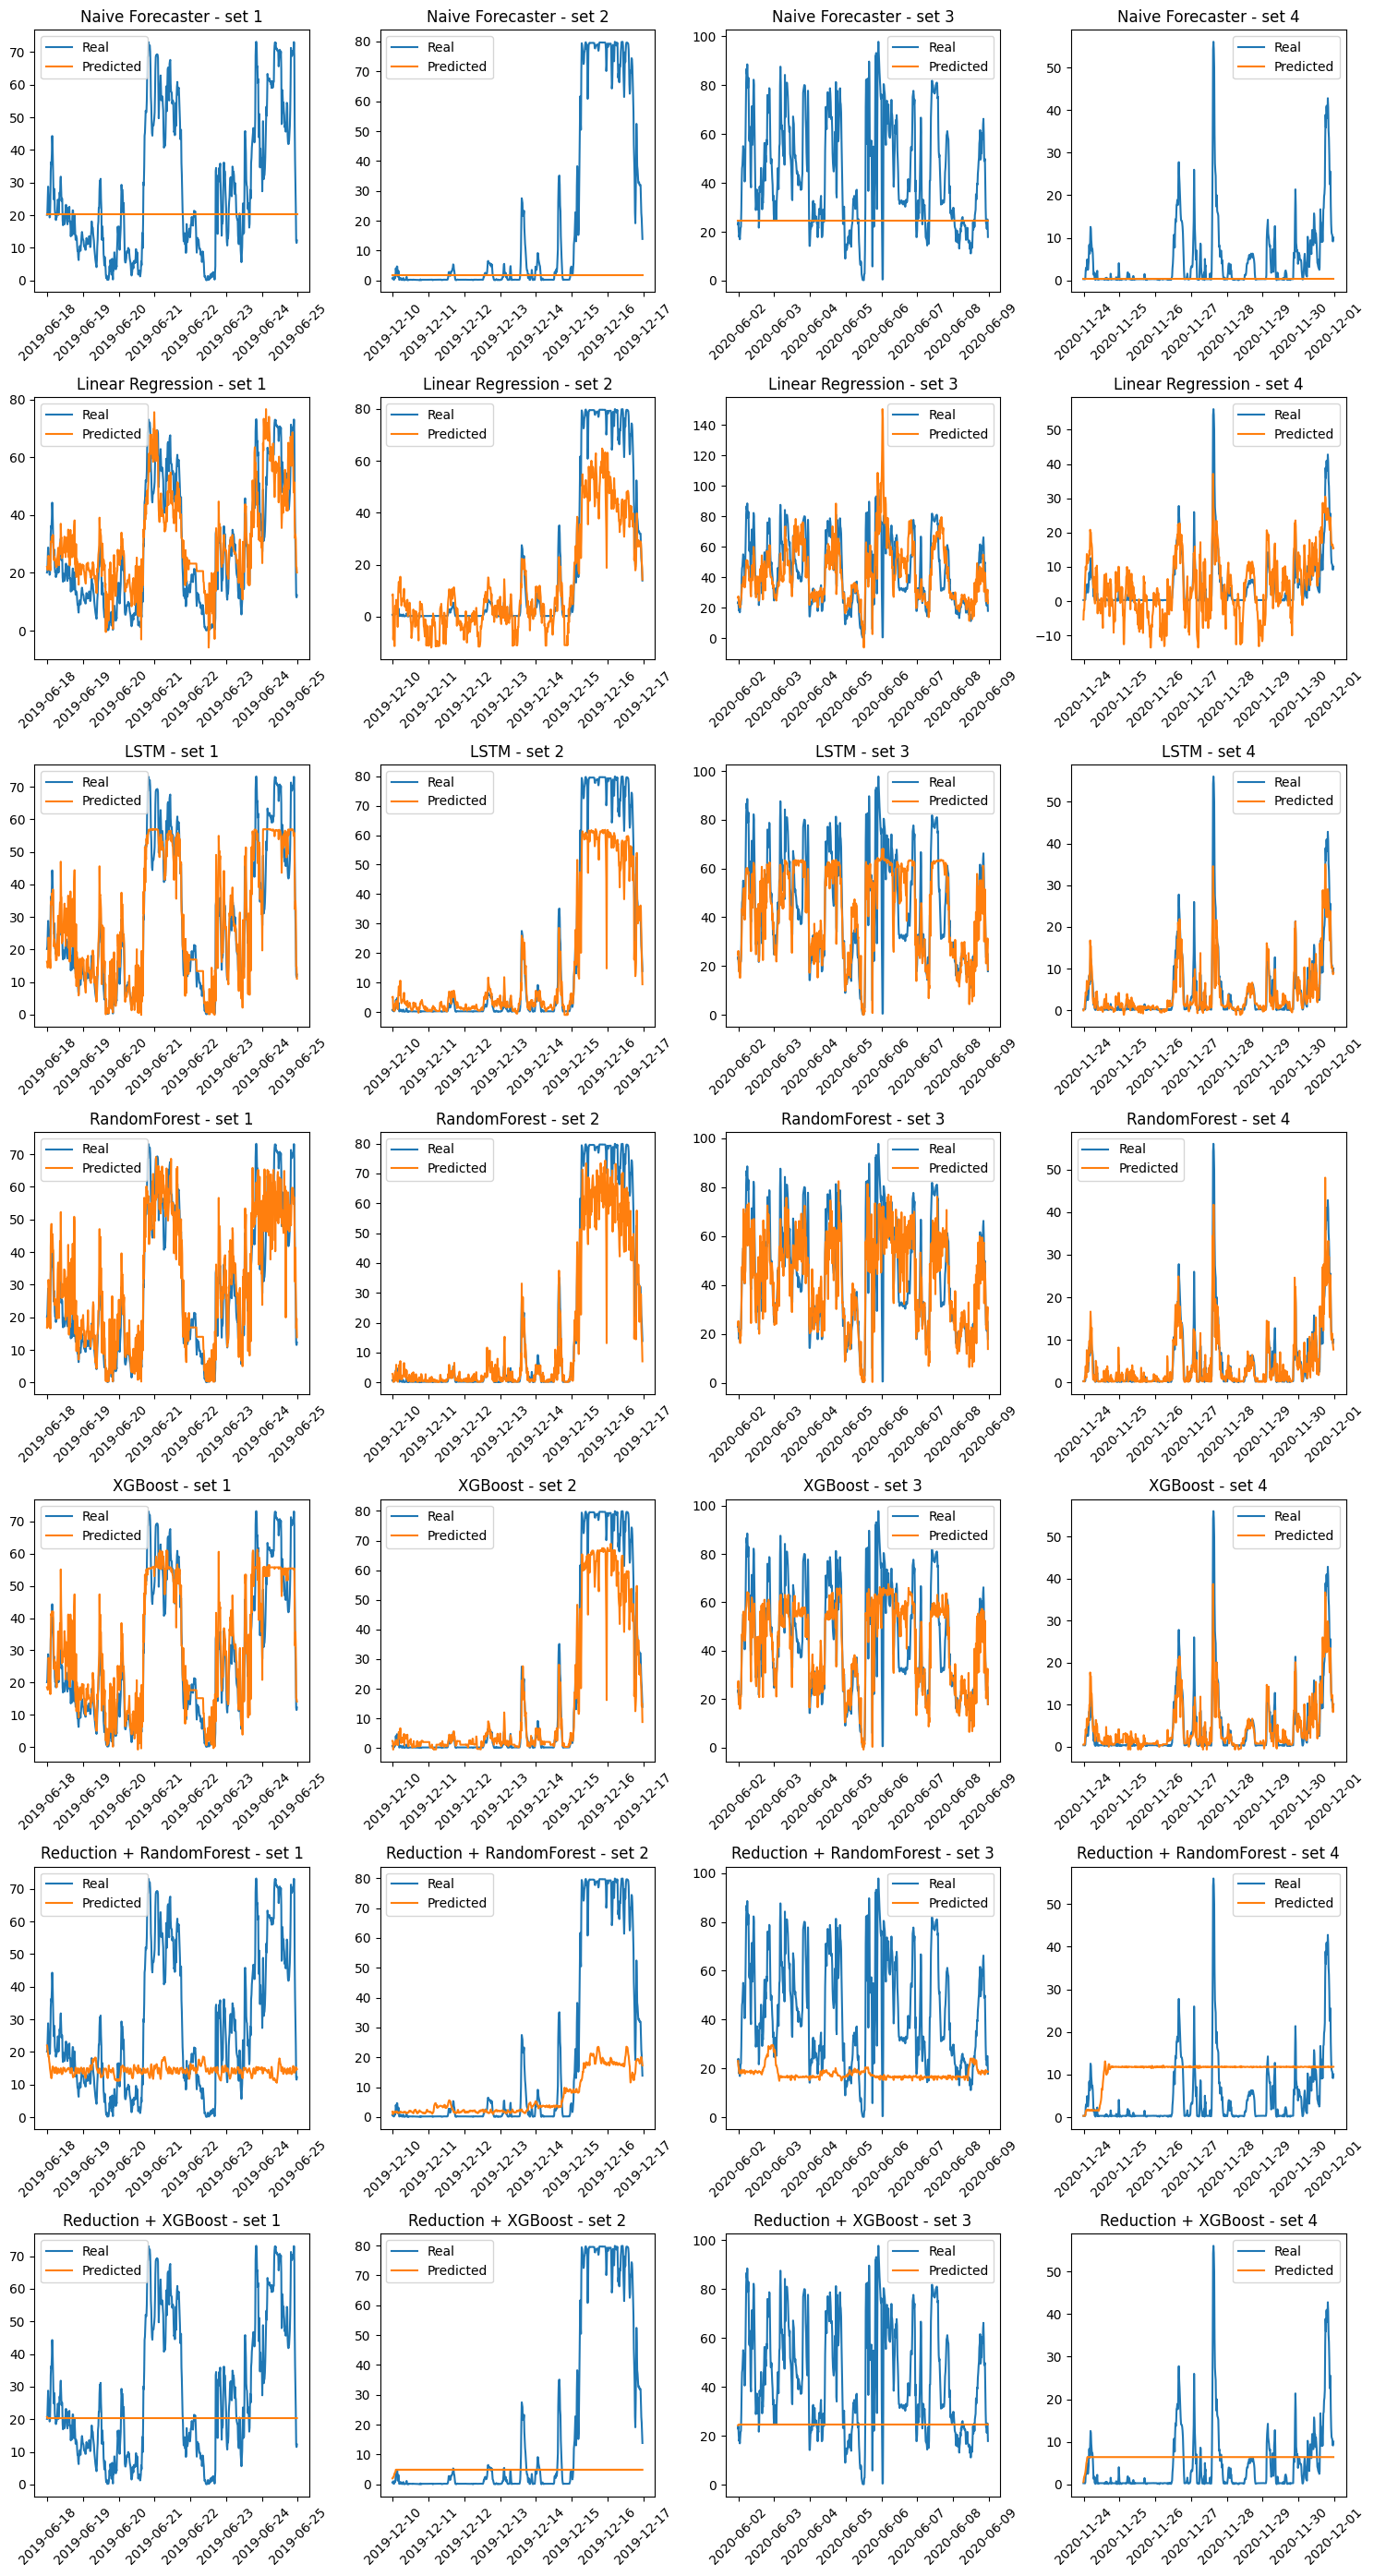

In [162]:
plt.figure(figsize=(15, 28))

# Plot Naive Forecaster
plt.subplot(7, 4, 1)
plt.plot(y_test_1, label='Real')
plt.plot(y_pred_naive_1, label='Predicted')
plt.title('Naive Forecaster - set 1')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(7, 4, 2)
plt.plot(y_test_2, label='Real')
plt.plot(y_pred_naive_2, label='Predicted')
plt.title('Naive Forecaster - set 2')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(7, 4, 3)
plt.plot(y_test_3, label='Real')
plt.plot(y_pred_naive_3, label='Predicted')
plt.title('Naive Forecaster - set 3')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(7, 4, 4)
plt.plot(y_test_4, label='Real')
plt.plot(y_pred_naive_4, label='Predicted')
plt.title('Naive Forecaster - set 4')
plt.legend()
plt.xticks(rotation=45)

# Plot Linear Regression
plt.subplot(7, 4, 5)
plt.plot(y_test_1, label='Real')
plt.plot(y_pred_linear_1, label='Predicted')
plt.title('Linear Regression - set 1')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(7, 4, 6)
plt.plot(y_test_2, label='Real')
plt.plot(y_pred_linear_2, label='Predicted')
plt.title('Linear Regression - set 2')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(7, 4, 7)
plt.plot(y_test_3, label='Real')
plt.plot(y_pred_linear_3, label='Predicted')
plt.title('Linear Regression - set 3')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(7, 4, 8)
plt.plot(y_test_4, label='Real')
plt.plot(y_pred_linear_4, label='Predicted')
plt.title('Linear Regression - set 4')
plt.legend()
plt.xticks(rotation=45)

# Plot LSTM
plt.subplot(7, 4, 9)
plt.plot(y_test_1, label='Real')
plt.plot(y_pred_lstm_1, label='Predicted')
plt.title('LSTM - set 1')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(7, 4, 10)
plt.plot(y_test_2, label='Real')
plt.plot(y_pred_lstm_2, label='Predicted')
plt.title('LSTM - set 2')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(7, 4, 11)
plt.plot(y_test_3, label='Real')
plt.plot(y_pred_lstm_3, label='Predicted')
plt.title('LSTM - set 3')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(7, 4, 12)
plt.plot(y_test_4, label='Real')
plt.plot(y_pred_lstm_4, label='Predicted')
plt.title('LSTM - set 4')
plt.legend()
plt.xticks(rotation=45)

# Plot RandomForest
plt.subplot(7, 4, 13)
plt.plot(y_test_1, label='Real')
plt.plot(y_pred_randomforest_1, label='Predicted')
plt.title('RandomForest - set 1')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(7, 4, 14)
plt.plot(y_test_2, label='Real')
plt.plot(y_pred_randomforest_2, label='Predicted')
plt.title('RandomForest - set 2')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(7, 4, 15)
plt.plot(y_test_3, label='Real')
plt.plot(y_pred_randomforest_3, label='Predicted')
plt.title('RandomForest - set 3')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(7, 4, 16)
plt.plot(y_test_4, label='Real')
plt.plot(y_pred_randomforest_4, label='Predicted')
plt.title('RandomForest - set 4')
plt.legend()
plt.xticks(rotation=45)

# Plot XGBoost
plt.subplot(7, 4, 17)
plt.plot(y_test_1, label='Real')
plt.plot(y_pred_xgboost_1, label='Predicted')
plt.title('XGBoost - set 1')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(7, 4, 18)
plt.plot(y_test_2, label='Real')
plt.plot(y_pred_xgboost_2, label='Predicted')
plt.title('XGBoost - set 2')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(7, 4, 19)
plt.plot(y_test_3, label='Real')
plt.plot(y_pred_xgboost_3, label='Predicted')
plt.title('XGBoost - set 3')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(7, 4, 20)
plt.plot(y_test_4, label='Real')
plt.plot(y_pred_xgboost_4, label='Predicted')
plt.title('XGBoost - set 4')
plt.legend()
plt.xticks(rotation=45)

# Plot Reduction + RandomForest
plt.subplot(7, 4, 21)
plt.plot(y_test_1, label='Real')
plt.plot(y_pred_reduction_randomforest_1, label='Predicted')
plt.title('Reduction + RandomForest - set 1')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(7, 4, 22)
plt.plot(y_test_2, label='Real')
plt.plot(y_pred_reduction_randomforest_2, label='Predicted')
plt.title('Reduction + RandomForest - set 2')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(7, 4, 23)
plt.plot(y_test_3, label='Real')
plt.plot(y_pred_reduction_randomforest_3, label='Predicted')
plt.title('Reduction + RandomForest - set 3')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(7, 4, 24)
plt.plot(y_test_4, label='Real')
plt.plot(y_pred_reduction_randomforest_4, label='Predicted')
plt.title('Reduction + RandomForest - set 4')
plt.legend()
plt.xticks(rotation=45)

# Plot Reduction + XGBoost
plt.subplot(7, 4, 25)
plt.plot(y_test_1, label='Real')
plt.plot(y_pred_reduction_xgboost_1, label='Predicted')
plt.title('Reduction + XGBoost - set 1')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(7, 4, 26)
plt.plot(y_test_2, label='Real')
plt.plot(y_pred_reduction_xgboost_2, label='Predicted')
plt.title('Reduction + XGBoost - set 2')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(7, 4, 27)
plt.plot(y_test_3, label='Real')
plt.plot(y_pred_reduction_xgboost_3, label='Predicted')
plt.title('Reduction + XGBoost - set 3')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(7, 4, 28)
plt.plot(y_test_4, label='Real')
plt.plot(y_pred_reduction_xgboost_4, label='Predicted')
plt.title('Reduction + XGBoost - set 4')
plt.legend()
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## **Backtesting**

In [ ]:
#model_lstm.update(df_wf1_test)